In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm

In [3]:
def load_tsv(filename: str) -> pd.DataFrame:
    return pd.read_csv(filename, header=0, sep="\t")

def load_csv(filename: str) -> pd.DataFrame:
    return pd.read_csv(filename)

In [4]:
# We load both eye tracking data and self-paced reading time data
# and merge the two dataframes

frank_ET = load_tsv("../../frank/eyetracking.RT.txt").dropna(subset=["subj_nr", "sent_nr", "word_pos"])
frank_SP = load_tsv("../../frank/selfpacedreading.RT.txt").dropna(subset=["subj_nr", "sent_nr", "word_pos"])

# We include entries for which we have only SP or only ET data
frank_both = frank_ET.merge(frank_SP, how="inner", on=["subj_nr", "word_pos", "sent_nr"])
frank_both["word_pos"] -= 1

# Function to aggregate the metrics for each token (over participants)
def make_grouped(df: pd.DataFrame, sent_col: str = "sent_nr", word_col: str = "word_pos") -> pd.DataFrame:
    return df.groupby(
        [sent_col, word_col]).mean(numeric_only=True).reset_index()

frank_both_grouped = make_grouped(frank_both)

In [5]:
# Functions to generate coloured scatterplots

def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]


def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]

def scatterplot(
        df: pd.DataFrame, x: str, y: str, color_col: str = "word_pos", s: int = 5,
        *args, **kwargs) -> None:
    df = df.dropna(axis="index", subset=[x, y])
    fig, ax = plt.subplots()
    df.plot(
        ax=ax, kind="scatter", x=x, y=y,
        c=df[color_col], cmap=cm.coolwarm, s=s, *args, **kwargs)

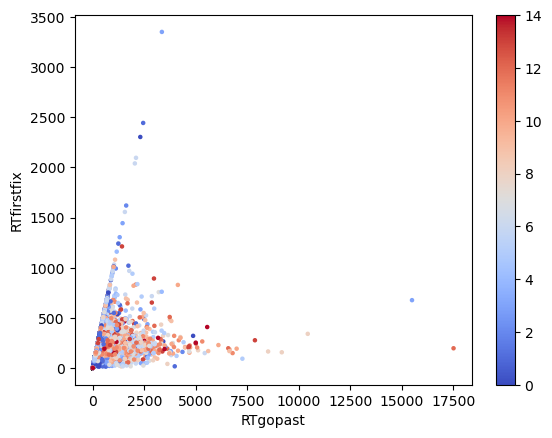

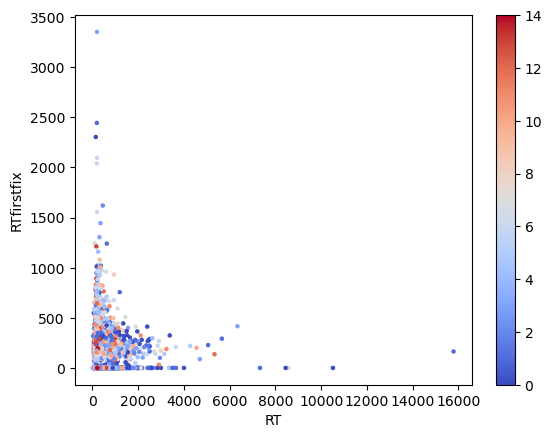

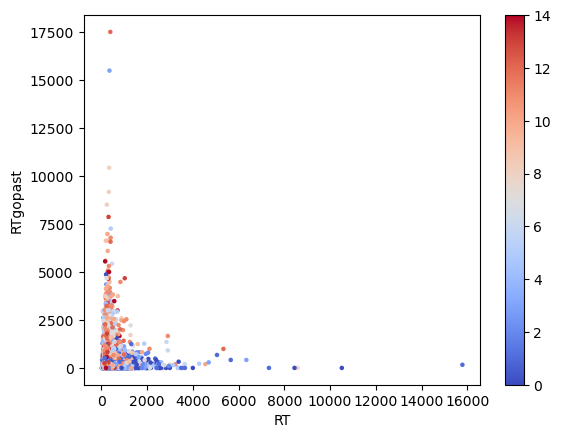

In [6]:
# We check how SPRT, FFD and GPT behave
# The colorbar refers to the position of a token in its sentence.

scatterplot(frank_both, "RTgopast", "RTfirstfix")
scatterplot(frank_both, "RT", "RTfirstfix")
scatterplot(frank_both, "RT", "RTgopast")

In [7]:
# Apparently, the further away a token is from the sentence beginning, the shorter its SPRT.
# For RT and GPT this is not so clear.

<Axes: xlabel='word_pos'>

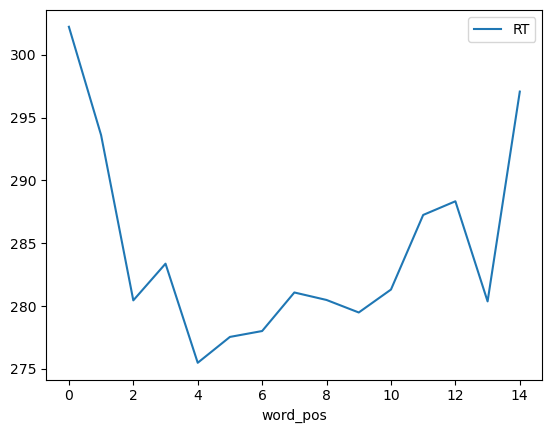

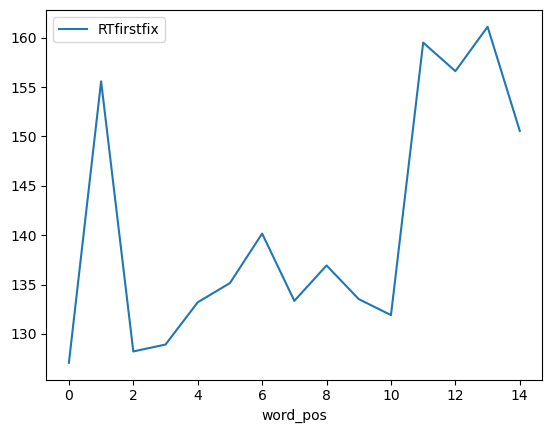

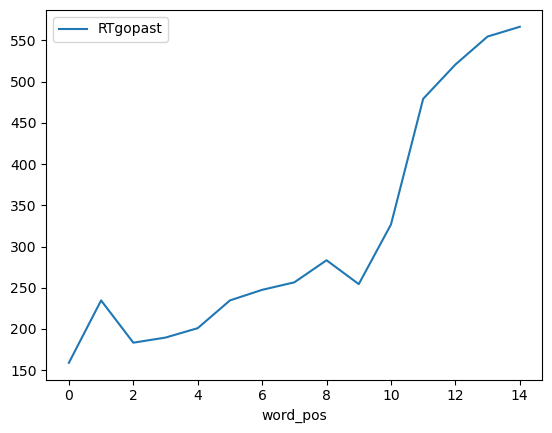

In [8]:
# Plot word position against RT metrics to see what relationship holds for FFD and GPT:

frank_both_grouped.groupby(["word_pos"]).mean(numeric_only=True).reset_index().plot(x="word_pos", y="RT")
frank_both_grouped.groupby(["word_pos"]).mean(numeric_only=True).reset_index().plot(x="word_pos", y="RTfirstfix")
frank_both_grouped.groupby(["word_pos"]).mean(numeric_only=True).reset_index().plot(x="word_pos", y="RTgopast")

In [9]:
# It seems like for FFD and GPT the opposite tendency holds: The further the
# sentence advances, the higher the metric.

<Axes: xlabel='word_pos'>

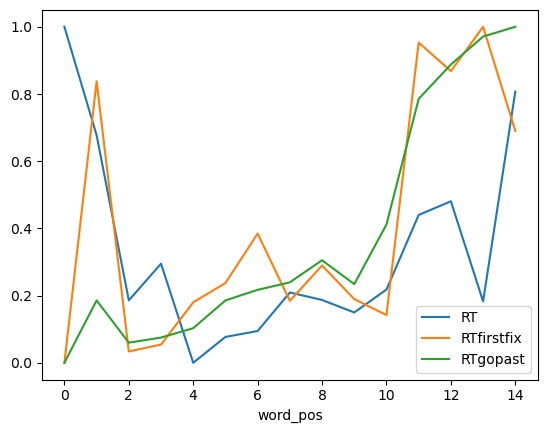

In [10]:
def minmaxnormalise(df: pd.DataFrame) -> pd.DataFrame:
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

bins = np.arange(0, 11)/10

frank_both_grouped = frank_both_grouped.merge(frank_both_grouped.groupby('sent_nr')['word_pos'].max().reset_index().rename(columns={'word_pos': 'max_pos'}), on='sent_nr')

minmaxnormalise(frank_both_grouped.groupby(["word_pos"])[["RT", "RTfirstfix", "RTgopast"]].mean()).plot()

<Axes: xlabel='word_pos'>

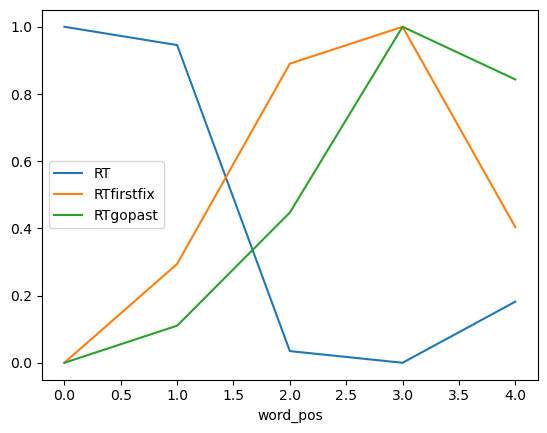

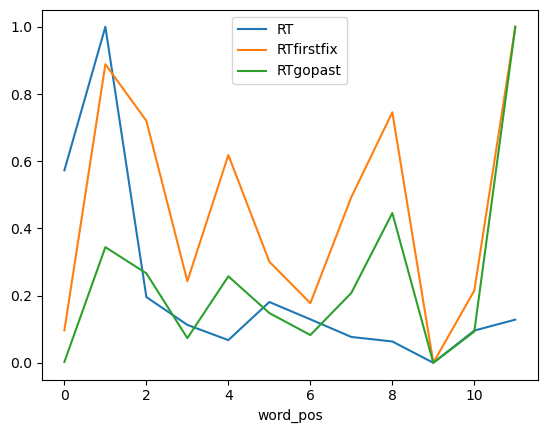

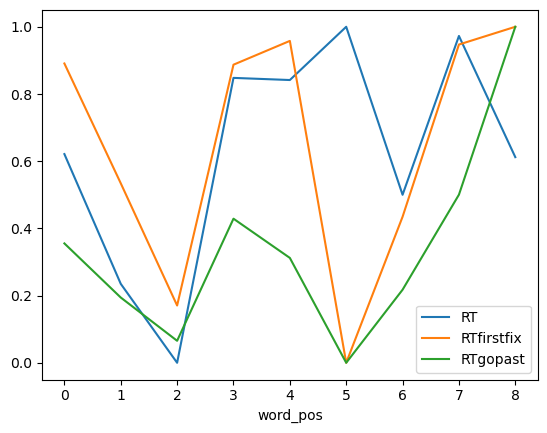

In [11]:
# Let's look at specific sentences

minmaxnormalise(frank_both_grouped[frank_both_grouped["sent_nr"] == 11][["RT", "RTfirstfix", "RTgopast", "word_pos"]].groupby("word_pos").mean(numeric_only=True)).plot()
minmaxnormalise(frank_both_grouped[frank_both_grouped["sent_nr"] == 150][["RT", "RTfirstfix", "RTgopast", "word_pos"]].groupby("word_pos").mean(numeric_only=True)).plot()
minmaxnormalise(frank_both_grouped[frank_both_grouped["sent_nr"] == 99][["RT", "RTfirstfix", "RTgopast", "word_pos"]].groupby("word_pos").mean(numeric_only=True)).plot()

<Axes: xlabel='word_pos'>

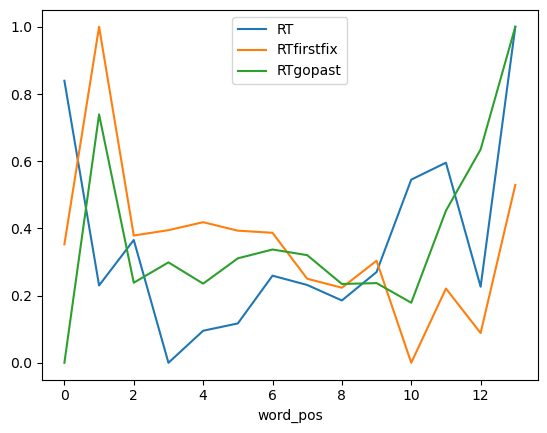

In [12]:
# Sooo... we seem to have a delay of 1 at RT. Let's shift RT by -1 steps
# and redraw the plots

grouped_by_sent = frank_both_grouped.groupby("sent_nr")
temp = frank_both_grouped.copy()
temp["sent_nr2"] = temp["sent_nr"]
shifted = temp.groupby("sent_nr2").shift(-1).dropna(subset=["sent_nr"])  #.groupby("sent_nr").apply(lambda group: group.iloc[1:]).droplevel(0)

def get_masker(to_remove):
    def make_mask(x):
        result = np.ones_like(x)
        result[to_remove] = 0
        return result
    return make_mask

mask = frank_both_grouped.groupby("sent_nr")["sent_nr"].transform(get_masker(-1)).astype(bool)
dropped = frank_both_grouped.loc[mask].copy()

dropped["RT"] = shifted["RT"]

minmaxnormalise(dropped.groupby(["word_pos"])[["RT", "RTfirstfix", "RTgopast"]].mean()).plot()


<Axes: xlabel='word_pos'>

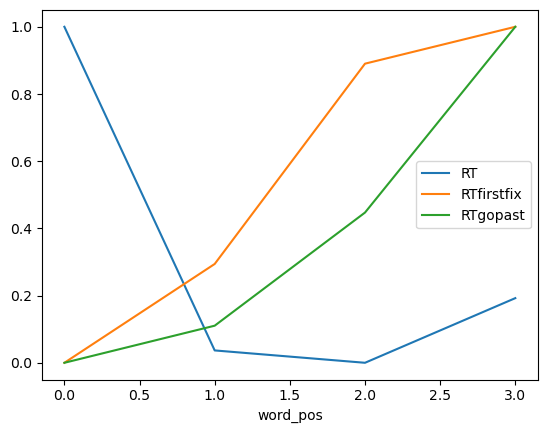

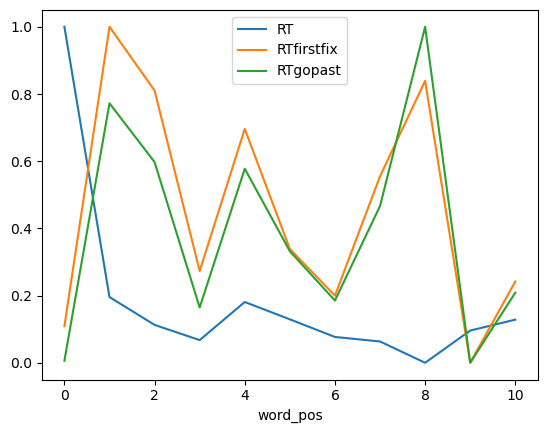

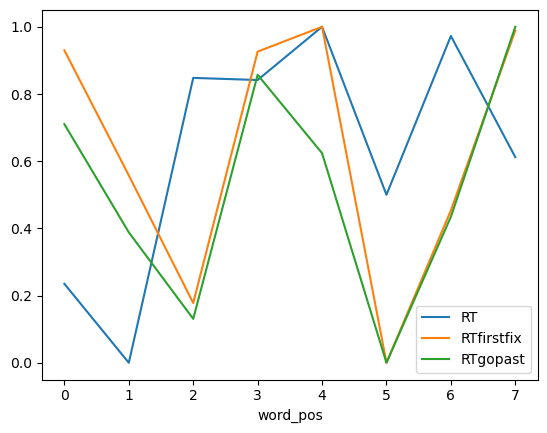

In [13]:
minmaxnormalise(dropped[dropped["sent_nr"] == 11][["RT", "RTfirstfix", "RTgopast", "word_pos"]].groupby("word_pos").mean(numeric_only=True)).plot()
minmaxnormalise(dropped[dropped["sent_nr"] == 150][["RT", "RTfirstfix", "RTgopast", "word_pos"]].groupby("word_pos").mean(numeric_only=True)).plot()
minmaxnormalise(dropped[dropped["sent_nr"] == 99][["RT", "RTfirstfix", "RTgopast", "word_pos"]].groupby("word_pos").mean(numeric_only=True)).plot()

In [14]:
# Let's compute correlations:

frank_both_grouped[["RT", "RTfirstfix", "RTgopast"]].corr()

,RT,RTfirstfix,RTgopast
RT,1.000000,0.107537,0.125126
RTfirstfix,0.107537,1.000000,0.712208
RTgopast,0.125126,0.712208,1.000000


In [15]:
dropped[["RT", "RTfirstfix", "RTgopast"]].corr()

,RT,RTfirstfix,RTgopast
RT,1.000000,0.072654,0.094248
RTfirstfix,0.072654,1.000000,0.853528
RTgopast,0.094248,0.853528,1.000000


In [16]:
# Apparently, shifting made correlations worse.

In [17]:
# Cut off one token from the start
mask = dropped.groupby("sent_nr")["sent_nr"].transform(get_masker(0)).astype(bool)
dropped.loc[mask].copy()[["RT", "RTfirstfix", "RTgopast"]].corr()

,RT,RTfirstfix,RTgopast
RT,1.000000,0.091298,0.127721
RTfirstfix,0.091298,1.000000,0.851053
RTgopast,0.127721,0.851053,1.000000


In [18]:
# Cut off one token from the start and end of unshifted dataframe
mask = frank_both_grouped.groupby("sent_nr")["sent_nr"].transform(get_masker([0, -1])).astype(bool)
frank_both_grouped.loc[mask].copy()[["RT", "RTfirstfix", "RTgopast"]].corr()

,RT,RTfirstfix,RTgopast
RT,1.000000,0.102046,0.111297
RTfirstfix,0.102046,1.000000,0.851053
RTgopast,0.111297,0.851053,1.000000


In [19]:
# Well... that did not improve things...
# What about the other measures

In [20]:
frank_both_grouped[["RT", "RTfirstfix", "RTgopast", "RTfirstpass", "RTrightbound"]].corr()

,RT,RTfirstfix,RTgopast,RTfirstpass,RTrightbound
RT,1.000000,0.107537,0.125126,0.134604,0.141357
RTfirstfix,0.107537,1.000000,0.712208,0.951537,0.922556
RTgopast,0.125126,0.712208,1.000000,0.750175,0.838580
RTfirstpass,0.134604,0.951537,0.750175,1.000000,0.968891
RTrightbound,0.141357,0.922556,0.838580,0.968891,1.000000


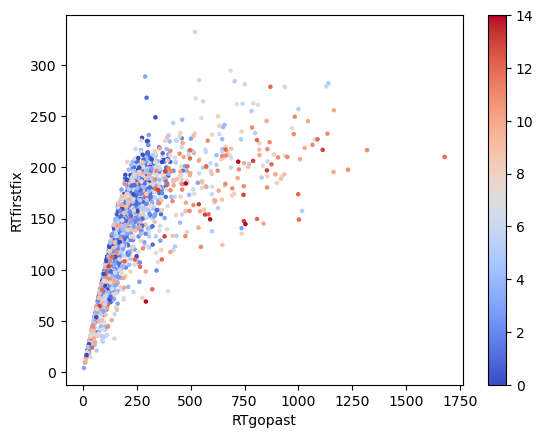

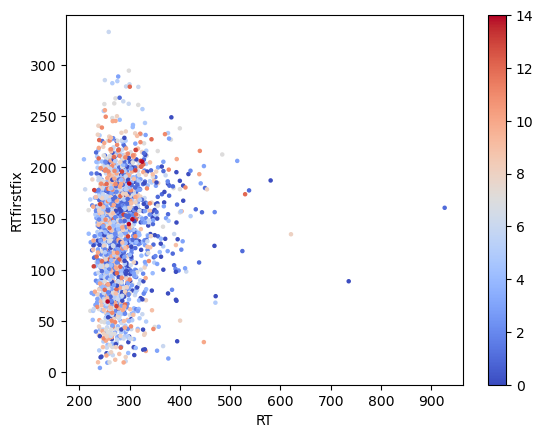

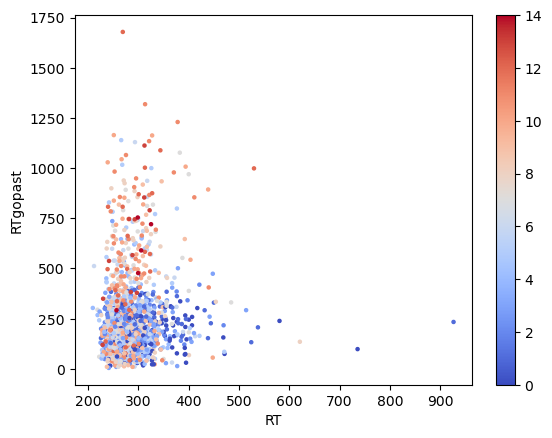

In [21]:
scatterplot(frank_both_grouped, "RTgopast", "RTfirstfix")
scatterplot(frank_both_grouped, "RT", "RTfirstfix")
scatterplot(frank_both_grouped, "RT", "RTgopast")

In [22]:
# There seem to be some systematic outliers. Are these the sentence ends?
# We need to plot them in the same colour to see this. 

In [23]:
# Therefore, we define a separate colour range for each sentence, painting
# the beginning of each sentence blue and the last item red.

from matplotlib import ticker

def scatterplot_2(
        df: pd.DataFrame, x: str, y: str, color_col: str = "word_pos", sent_col: str = "sent_nr", s: int = 5,
        *args, **kwargs) -> None:
    df = df.dropna(axis="index", subset=[x, y])
    fig, ax = plt.subplots()
    plot_colorbar = True
    for sent in df[sent_col].unique():
        sent_df = df[df[sent_col].eq(sent)].copy()
        max_pos = sent_df[color_col].max()
        sent_df["word_pos_perc"] = sent_df[color_col] / max_pos
        sent_df.plot(
            ax=ax, kind="scatter", x=x, y=y,
            c=sent_df["word_pos_perc"], cmap=cm.coolwarm, s=s, colorbar=plot_colorbar, *args, **kwargs)
        plot_colorbar = False
    cax = fig.get_axes()[1]
    labels = cax.get_yticklabels()
    step = 1/(len(labels)-1)
    cax.set_yticks(cax.get_yticks())
    cax.set_yticklabels(list(np.arange(0, 1+step, step)))



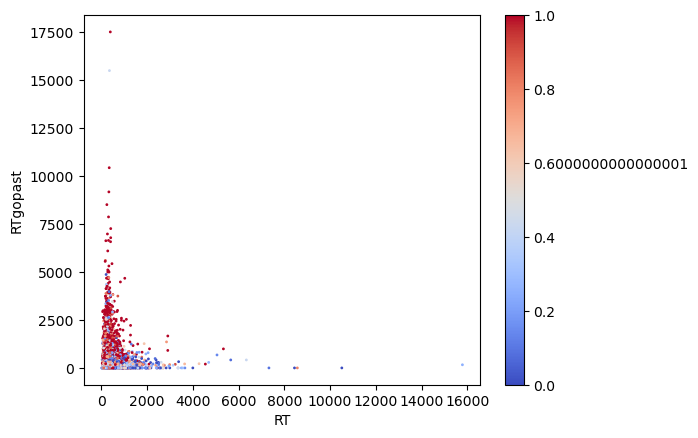

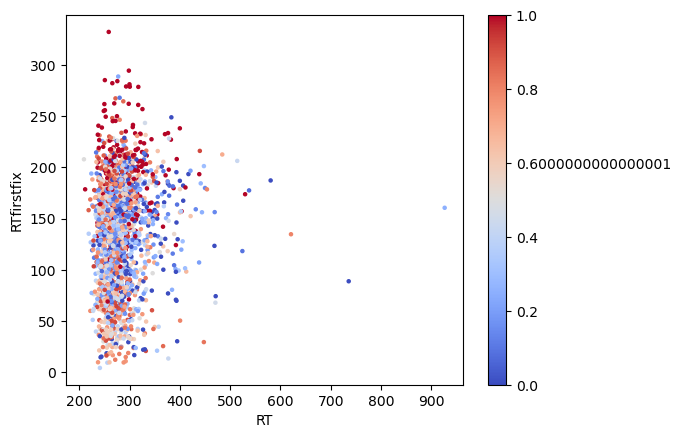

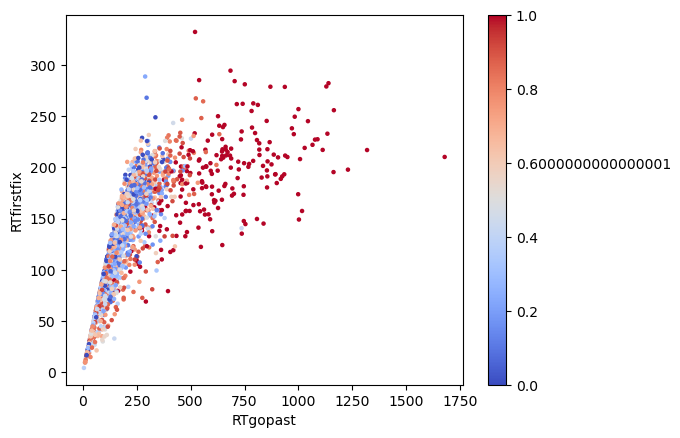

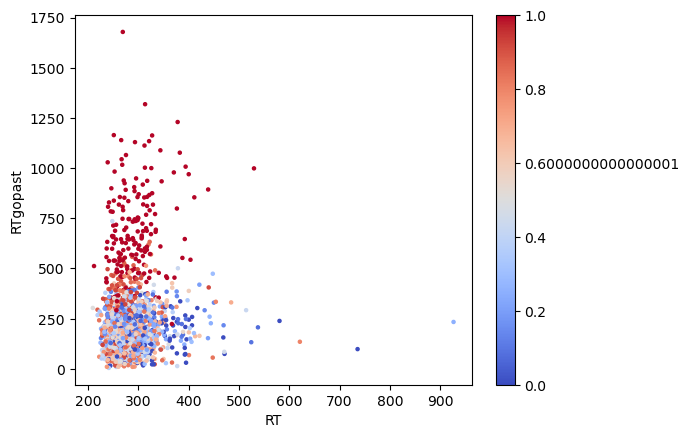

In [24]:
scatterplot_2(frank_both, "RT", "RTgopast", s=1)
scatterplot_2(frank_both_grouped, "RT", "RTfirstfix")
scatterplot_2(frank_both_grouped, "RTgopast", "RTfirstfix")
scatterplot_2(frank_both_grouped, "RT", "RTgopast")

/tmp/ipykernel_6786/1365349166.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby("binned_perc").mean(numeric_only=True).reset_index()


<Axes: xlabel='binned_perc'>

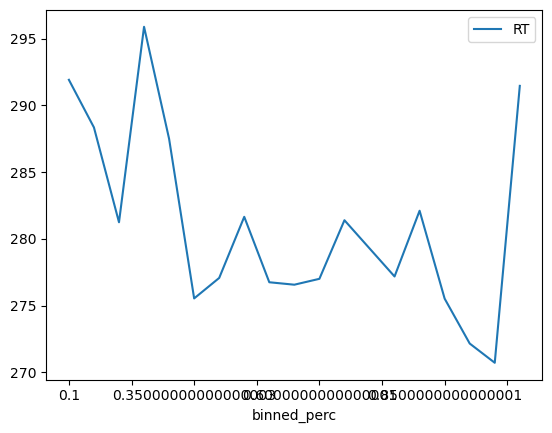

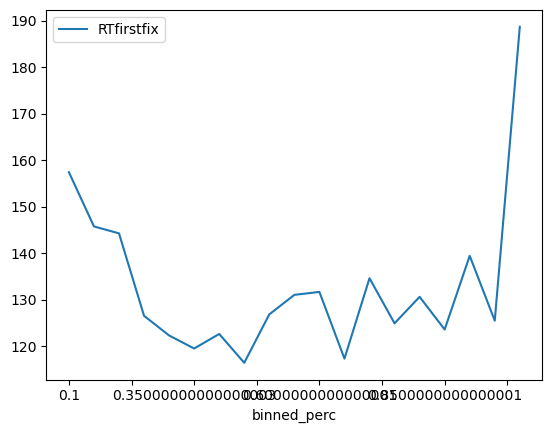

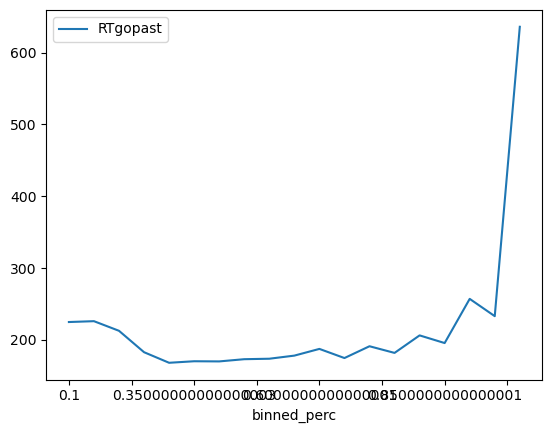

In [25]:
# Indeed, the last item in a sentence appears to exhibit a larger GPT than expected.

# Now we repeat the plot that shows position against RT metrics with position relative
# to overall sentence length

temp = frank_both_grouped.copy()
temp["word_pos_perc"] = temp["word_pos"] / temp["max_pos"]

# We make bins
step_size = 0.05
bins = np.arange(0, 1+step_size, step_size)
temp["binned_perc"] = pd.cut(temp['word_pos_perc'], bins, labels=bins[1:])
temp = temp.groupby("binned_perc").mean(numeric_only=True).reset_index()

temp.dropna(subset=["RT"]).plot(x="binned_perc", y="RT")
temp.dropna(subset=["RTfirstfix"]).plot(x="binned_perc", y="RTfirstfix")
temp.dropna(subset=["RTgopast"]).plot(x="binned_perc", y="RTgopast")

In [26]:
# All three metrics experience a rise towards the end. For GPT this rise is around 6 times higher than the signal
# in other regions of the sentence. While in RT it is approximately as high as the signal in the beginning.
# This is probably the case because in ET the reader have access to the previous stimulus while in SP they do no

# So ideally we want to cut off the end because it corrodes our observational measures.

<Axes: xlabel='binned_perc'>

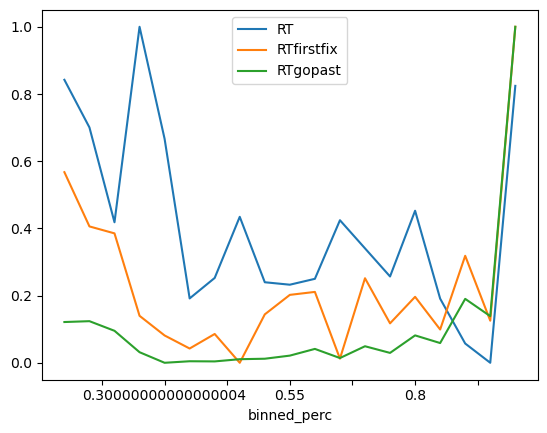

In [27]:
def minmaxnormalise(df: pd.DataFrame, ignore: set[str] = set()) -> pd.DataFrame:
    result = df.copy()
    for feature_name in df.columns:
        if not feature_name in ignore:
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

minmaxnormalise(temp, ignore={"binned_perc"})[["binned_perc", "RT", "RTfirstfix", "RTgopast"]].plot(x="binned_perc")

In [28]:
# Now let's load data that dropped the very last and the first token in each sentence.
# Let's load only sentence of the length that occurs in both subsets (ET data has a lower limit) to not
# dilute a part of our evaluation

frank_SP2 = load_csv("../../RT/data/frank_SP_preprocessed_exp1_current_1.00_0.csv").dropna(subset=["WorkerId", "item", "zone"])
frank_ET2 = load_csv("../../RT/data/frank_ET_preprocessed_exp1_current_1.00_0.csv").dropna(subset=["WorkerId", "item", "zone"])
frank_both2 = frank_ET2.merge(frank_SP2, how="outer", on=[
    "item", "zone", "WorkerId", "word", "length", "surprisal", "position", "expected_distance", "kl_divergence", "head_distance",
    "demberg","first_dependent_distance", "first_dependent_correct", "first_dependent_distance_weight", "left_dependents_distance_sum",
    "left_dependents_count", "deprel", "pos", "first_dependent_deprel", "frequency", "surprisal.s", "frequency.s", "length.s", "demberg.1", "demberg.2", "surprisal.1", "surprisal.2"])

# Reduce zone by one so it starts from 1
frank_both2["zone"] -= 2

sent_max = frank_both2.groupby("item")["zone"].max().reset_index()
sent_max = sent_max.rename(columns={"zone": "zone_max"})

frank_both2 = frank_both2.merge(
    sent_max, on=["item"], how="inner")

frank_both2 = frank_both2[frank_both2["zone_max"] < frank_both2[~frank_both2["FFD"].isna()]["zone_max"].max()+1]
frank_both_grouped2 = make_grouped(frank_both2, sent_col="item", word_col="zone")

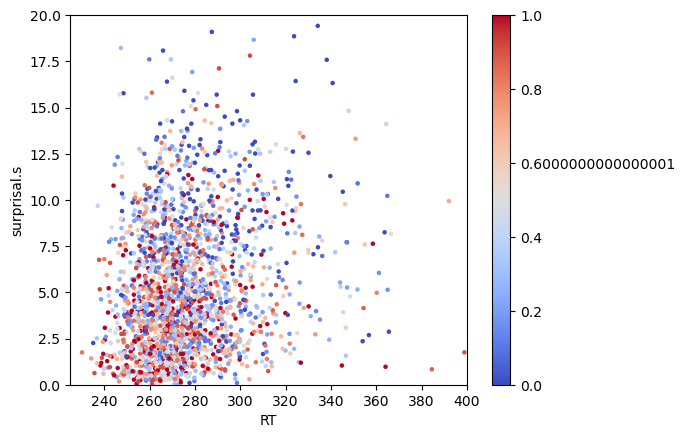

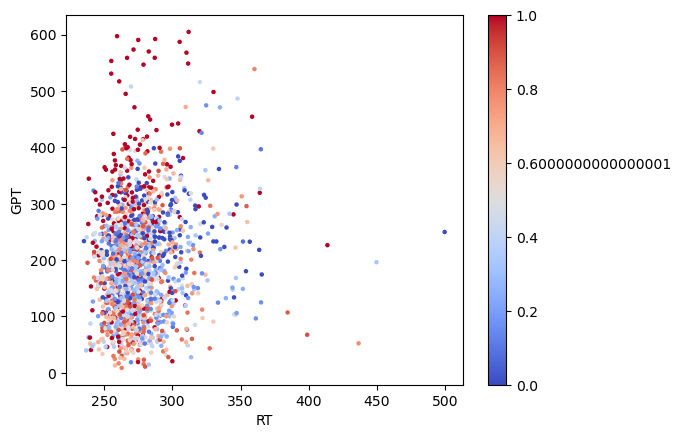

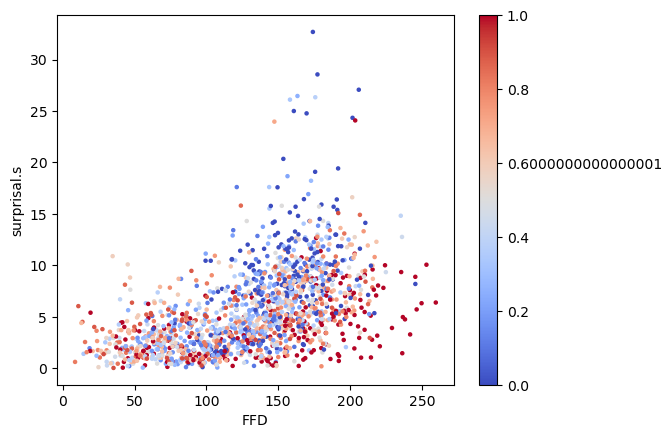

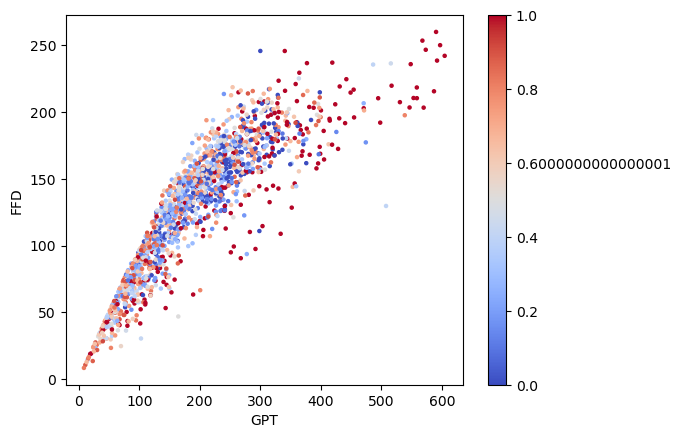

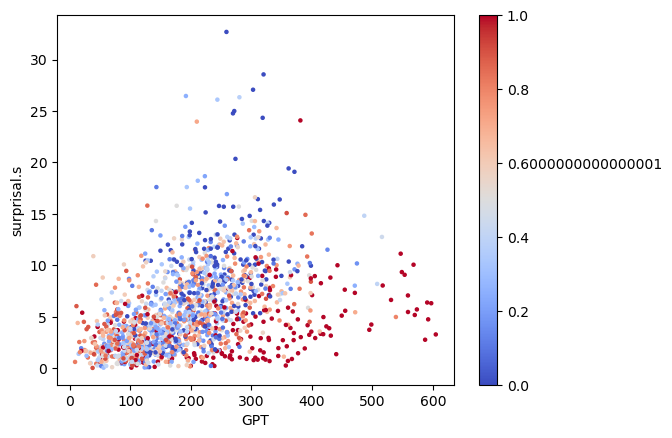

In [29]:
# Look at the plots given the data without first and last tokens

scatterplot_2(frank_both_grouped2, "RT", "surprisal.s", sent_col="item", color_col="zone", xlim=(225, 400), ylim=(0, 20))
scatterplot_2(frank_both_grouped2, "RT", "GPT", sent_col="item", color_col="zone")
scatterplot_2(frank_both_grouped2, "FFD", "surprisal.s", sent_col="item", color_col="zone")
scatterplot_2(frank_both_grouped2, "GPT", "FFD", sent_col="item", color_col="zone")
scatterplot_2(frank_both_grouped2, "GPT", "surprisal.s", sent_col="item", color_col="zone")

# TODO: Why is part of the colorbar white?

(0.0, 15.0)

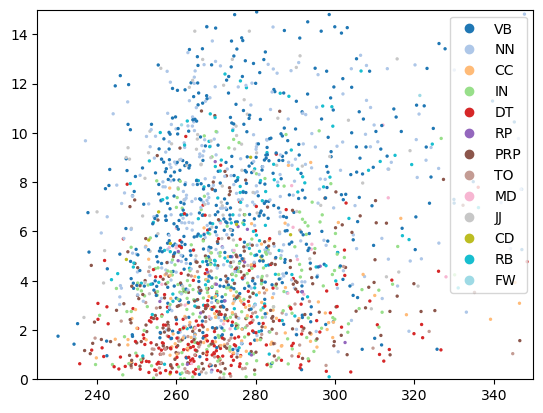

In [30]:
frank_both_grouped2["pos"] = frank_both2.groupby(["item", "zone"]).first().reset_index()["pos"]
pos_tags = frank_both_grouped2["pos"].unique()
pos2id = {pos: i for i, pos in enumerate(pos_tags)}
ids = [pos2id[pos] for pos in frank_both_grouped2["pos"]]

fig, ax = plt.subplots()
scatter = ax.scatter(frank_both_grouped2["RT"], frank_both_grouped2["surprisal.s"], s=2, c=ids, cmap=cm.tab20)
elements = scatter.legend_elements()[0]
legend = ax.legend(elements, pos_tags)
ax.set_xlim(225, 350)
ax.set_ylim(0,15)

(0.0, 15.0)

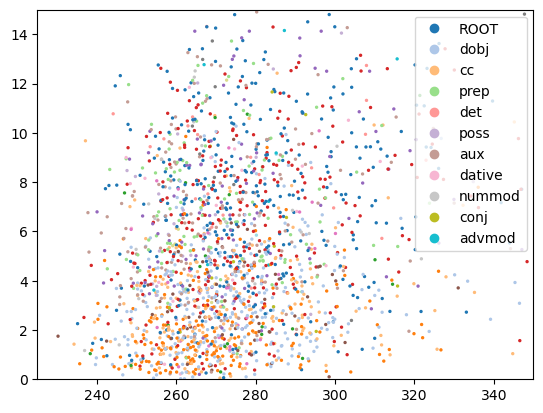

In [31]:
frank_both_grouped2["deprel"] = frank_both2.groupby(["item", "zone"]).first().reset_index()["deprel"]
pos_tags = frank_both_grouped2["deprel"].unique()
pos2id = {pos: i for i, pos in enumerate(pos_tags)}
ids = [pos2id[pos] for pos in frank_both_grouped2["deprel"]]

fig, ax = plt.subplots()
scatter = ax.scatter(frank_both_grouped2["RT"], frank_both_grouped2["surprisal.s"], s=2, c=ids, cmap=cm.tab20)
elements = scatter.legend_elements()[0]
legend = ax.legend(elements, pos_tags)
ax.set_xlim(225, 350)
ax.set_ylim(0,15)

In [32]:
# Rename columns so that they are easier to understand

frank_both2 = frank_both2.rename(columns={
    "surprisal": "surprisal",
    "surprisal.1": "surprisal+1",
    "surprisal.2": "surprisal-1",
    "demberg": "demberg",
    "demberg.1": "demberg+1",
    "demberg.2": "demberg-1",
})

In [33]:
# Check Pearson correlation coefficients between metrics and candidates

def get_proportional(frank_both2: pd.DataFrame) -> pd.DataFrame:
    frank_both_proportional2 = frank_both2.copy()
    frank_both_proportional2 = frank_both_proportional2.rename(columns={
        "surprisal": "surprisal",
        "surprisal.1": "surprisal+1",
        "surprisal.2": "surprisal-1",
        "demberg": "demberg",
        "demberg.1": "demberg+1",
        "demberg.2": "demberg-1"
    })
    sent_max2 = frank_both_proportional2.groupby("item")["zone"].max().reset_index()
    sent_max2 = sent_max2.rename(columns={"zone": "zone_max2"})
    frank_both_proportional2 = frank_both_proportional2.merge(
        sent_max2, on=["item"], how="outer")
    frank_both_proportional2["percent_of_sent"] = frank_both_proportional2["zone"] / frank_both_proportional2["zone_max2"]
    return frank_both_proportional2

frank_both_proportional2 = get_proportional(frank_both2)
frank_both_proportional2[["RT", "FFD", "GPT", "surprisal", "demberg", "frequency", "length", "position", "percent_of_sent"]].corr()

,RT,FFD,GPT,surprisal,demberg,frequency,length,position,percent_of_sent
RT,1.000000,0.026828,0.027020,0.021308,0.007108,-0.016687,0.021144,-0.016144,-0.016842
FFD,0.026828,1.000000,0.598366,0.210517,0.161156,-0.280880,0.294344,-0.061575,-0.022394
GPT,0.027020,0.598366,1.000000,0.161000,0.114191,-0.204812,0.222857,-0.025936,0.021749
surprisal,0.021308,0.210517,0.161000,1.000000,0.373723,-0.686432,0.556958,-0.231684,-0.248127
demberg,0.007108,0.161156,0.114191,0.373723,1.000000,-0.548648,0.378455,-0.019780,-0.047960
frequency,-0.016687,-0.280880,-0.204812,-0.686432,-0.548648,1.000000,-0.731736,0.178801,0.196020
length,0.021144,0.294344,0.222857,0.556958,0.378455,-0.731736,1.000000,-0.140308,-0.138434
position,-0.016144,-0.061575,-0.025936,-0.231684,-0.019780,0.178801,-0.140308,1.000000,0.839700
percent_of_sent,-0.016842,-0.022394,0.021749,-0.248127,-0.047960,0.196020,-0.138434,0.839700,1.000000


In [34]:
# Check PCC after taking token-wise mean
# Also print spillover and prediction correlation

In [106]:
next(iter(frank_both_proportional_grouped2))

'item'

In [119]:
def print_table(df: pd.DataFrame, sep: str = ' & ', linesep: str = ' \\ ', round_to: None | int = 2) -> str:
    output = ""
    for line_num in range(len(df)):
        output += sep.join([df.iloc[line_num].name] + [str(value if round_to is None else round(value, round_to)) for value in df.iloc[line_num]])
        output += linesep
    return output

In [122]:
to_correlate = ["RT", "FFD", "GPT", "surprisal", "surprisal+1", "surprisal-1", "demberg", "demberg+1", "demberg-1",] #  "frequency", "length", "position", "percent_of_sent",]
frank_both_proportional_grouped2 = make_grouped(frank_both_proportional2, sent_col="item", word_col="position") 
table = frank_both_proportional_grouped2[to_correlate].corr(method="pearson")
table

,RT,FFD,GPT,surprisal,surprisal+1,surprisal-1,demberg,demberg+1,demberg-1
RT,1.000000,0.095742,0.150340,0.164025,0.186387,0.022948,0.053182,0.017334,-0.027035
FFD,0.095742,1.000000,0.874829,0.508513,-0.111258,-0.021846,0.389632,-0.243252,-0.136778
GPT,0.150340,0.874829,1.000000,0.434464,-0.082911,0.046283,0.308318,-0.191662,-0.095746
surprisal,0.164025,0.508513,0.434464,1.000000,0.100084,0.037006,0.371481,-0.097297,-0.094275
surprisal+1,0.186387,-0.111258,-0.082911,0.100084,1.000000,0.029502,-0.069346,0.360842,-0.048612
surprisal-1,0.022948,-0.021846,0.046283,0.037006,0.029502,1.000000,-0.126776,-0.043717,0.393050
demberg,0.053182,0.389632,0.308318,0.371481,-0.069346,-0.126776,1.000000,-0.169624,-0.190733
demberg+1,0.017334,-0.243252,-0.191662,-0.097297,0.360842,-0.043717,-0.169624,1.000000,-0.036213
demberg-1,-0.027035,-0.136778,-0.095746,-0.094275,-0.048612,0.393050,-0.190733,-0.036213,1.000000


In [36]:
# We can see a lot:
# 

In [73]:
frank_both_proportional_grouped2[to_correlate].corr(method="spearman")

# We have a higher correlation for RT and surprisal+1 than with Pearson. Maybe the correlation is not linear?

,RT,FFD,GPT,surprisal,surprisal+1,surprisal-1,demberg,demberg+1,demberg-1,frequency,length,position,percent_of_sent
RT,1.000000,0.107128,0.139063,0.185251,0.260117,0.000719,0.069293,0.082618,-0.043116,-0.132366,0.150499,-0.140211,-0.140781
FFD,0.107128,1.000000,0.913065,0.577615,-0.125403,-0.033894,0.452113,-0.231911,-0.170291,-0.700919,0.779289,-0.131851,-0.035883
GPT,0.139063,0.913065,1.000000,0.528739,-0.098050,0.019767,0.389993,-0.215213,-0.123832,-0.616776,0.698638,-0.134278,-0.010828
surprisal,0.185251,0.577615,0.528739,1.000000,0.002948,-0.076790,0.482715,-0.085307,-0.210223,-0.750310,0.609954,-0.243855,-0.241419
surprisal+1,0.260117,-0.125403,-0.098050,0.002948,1.000000,0.013237,-0.137717,0.473887,-0.030284,0.118374,-0.108563,-0.232005,-0.197372
surprisal-1,0.000719,-0.033894,0.019767,-0.076790,0.013237,1.000000,-0.123660,-0.049107,0.485691,0.185033,-0.069722,-0.036538,0.052882
demberg,0.069293,0.452113,0.389993,0.482715,-0.137717,-0.123660,1.000000,-0.204660,-0.254483,-0.653649,0.492159,-0.136591,-0.154906
demberg+1,0.082618,-0.231911,-0.215213,-0.085307,0.473887,-0.049107,-0.204660,1.000000,-0.052260,0.185938,-0.172028,-0.019731,-0.001690
demberg-1,-0.043116,-0.170291,-0.123832,-0.210223,-0.030284,0.485691,-0.254483,-0.052260,1.000000,0.304025,-0.165587,0.040847,0.069232
frequency,-0.132366,-0.700919,-0.616776,-0.750310,0.118374,0.185033,-0.653649,0.185938,0.304025,1.000000,-0.764162,0.179927,0.194237


/tmp/ipykernel_6786/3638643051.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby("binned_perc").mean(numeric_only=True).reset_index()


<Axes: xlabel='binned_perc'>

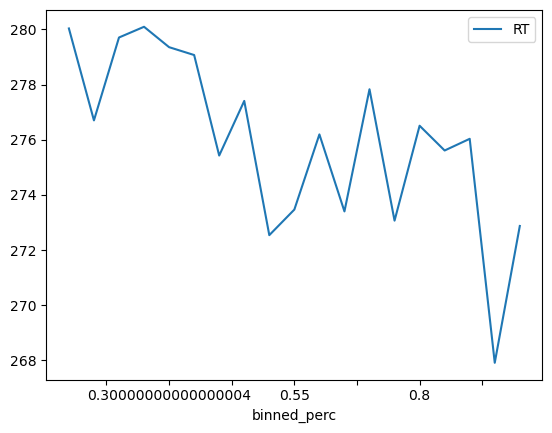

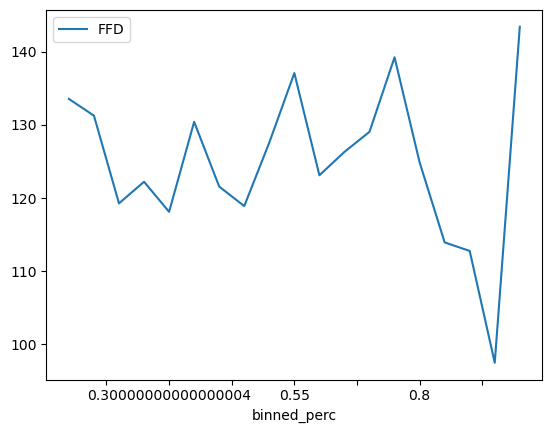

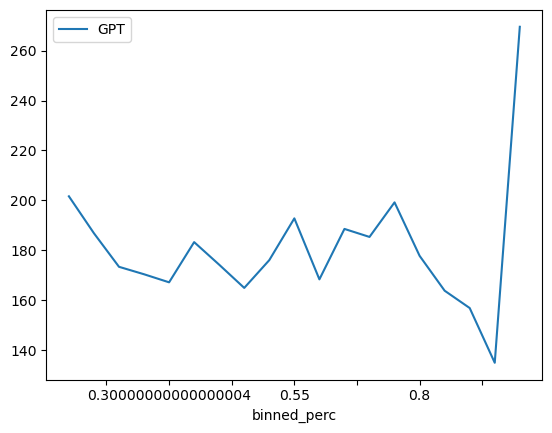

In [65]:
# Now we repeat the plot that shows position against RT metrics with position relative
# to overall sentence length

temp = frank_both_grouped2.copy()
max_pos = temp.groupby(["item"])["zone"].max().reset_index().rename(columns={"zone": "max_zone"})
temp = temp.merge(max_pos, how="inner", on="item")
temp["zone_perc"] = temp["zone"] / temp["max_zone"]

# We make bins
step_size = 0.05
bins = np.arange(0, 1+step_size, step_size)
temp["binned_perc"] = pd.cut(temp['zone_perc'], bins, labels=bins[1:])
temp = temp.groupby("binned_perc").mean(numeric_only=True).reset_index()

temp.plot(x="binned_perc", y="RT")
temp.plot(x="binned_perc", y="FFD")
temp.plot(x="binned_perc", y="GPT")

/tmp/ipykernel_6786/2357119937.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  minmaxnormalise(frank_both_proportional_grouped2.groupby(["binned"])[["surprisal", "RT", "FFD", "GPT", "-zone"]].mean()).plot()


<Axes: xlabel='binned'>

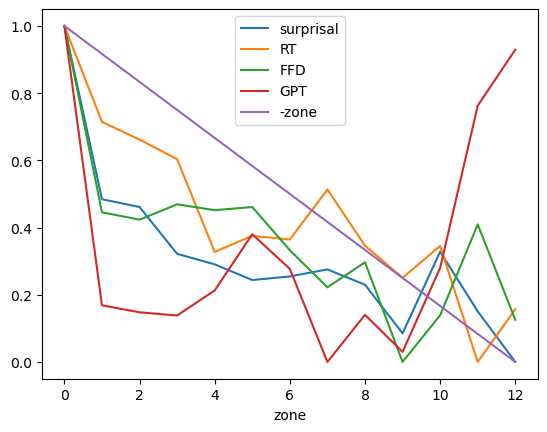

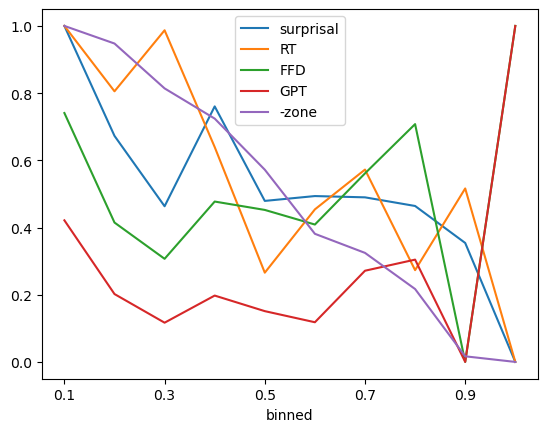

In [38]:
bins = np.arange(0, 11)/10
frank_both_proportional_grouped2['binned'] = pd.cut(frank_both_proportional_grouped2['percent_of_sent'], bins, labels=bins[1:])
frank_both_proportional_grouped2['-zone'] = -frank_both_proportional_grouped2['zone']

minmaxnormalise(frank_both_proportional_grouped2.groupby(["zone"])[["surprisal", "RT", "FFD", "GPT", "-zone"]].mean()).plot()
minmaxnormalise(frank_both_proportional_grouped2.groupby(["binned"])[["surprisal", "RT", "FFD", "GPT", "-zone"]].mean()).plot()

<Axes: xlabel='zone'>

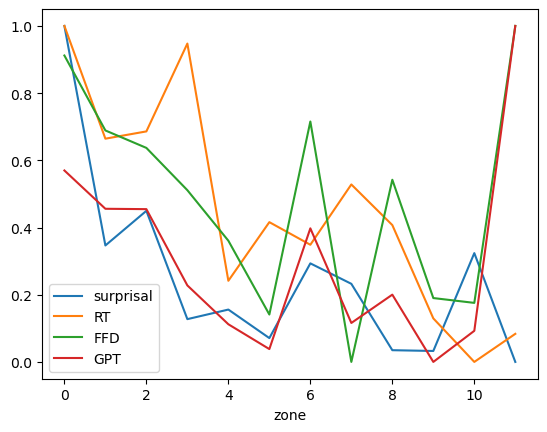

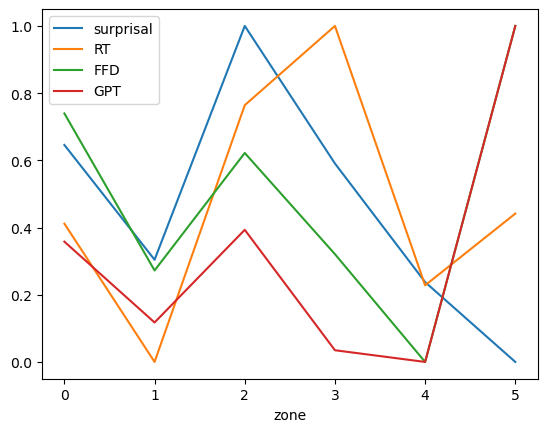

In [39]:
# Let's look at sentences of a specific length

minmaxnormalise(frank_both_proportional_grouped2[frank_both_proportional_grouped2["zone_max"] == 11][["surprisal", "RT", "FFD", "GPT", "zone"]].groupby("zone").mean(numeric_only=True)).plot()
minmaxnormalise(frank_both_proportional_grouped2[frank_both_proportional_grouped2["zone_max"] == 5][["surprisal", "RT", "FFD", "GPT", "zone"]].groupby("zone").mean(numeric_only=True)).plot()

In [68]:
# RT, FFD, GPT seem to have a similar development inside a sentence, except for the end where RT goes down and FFD and GPT goes up.
# Maybe cut off one additional last element?
# The same holds for surprisal.
# We seem to have higher spillover effects for RT (see correlation matrix) while ET metrics are closer to surprisal.

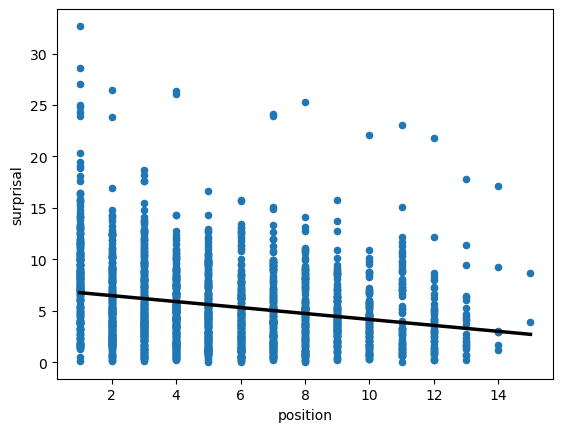

In [41]:
def regression(df: pd.DataFrame, x: str, y: str) -> None:
    fig, ax = plt.subplots()

    df.plot(ax=ax, kind="scatter", x=x, y=y)

    b, a = np.polyfit(df[x], df[y], deg=1)

    # Create sequence of 100 numbers from 0 to 100
    xseq = np.linspace(frank_both_proportional_grouped2[x].min(), frank_both_proportional_grouped2[x].max(), num=100)

    # Plot regression line
    ax.plot(xseq, a + b * xseq, color="k", lw=2.5)

regression(frank_both_proportional_grouped2, "position", "surprisal")

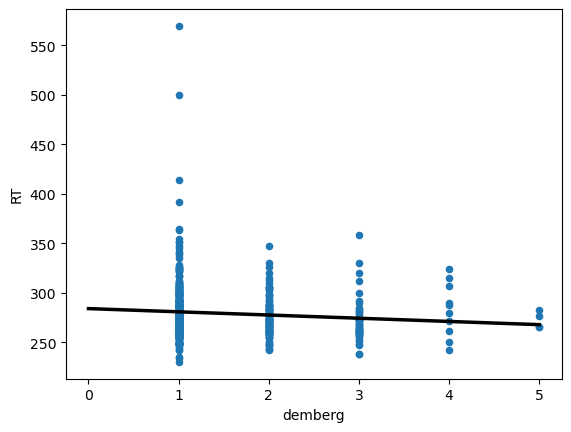

In [42]:
fvb_g = make_grouped(frank_both_proportional2[frank_both_proportional2["pos"] == "VB"], sent_col="item", word_col="position")
regression(fvb_g, "demberg", "RT")

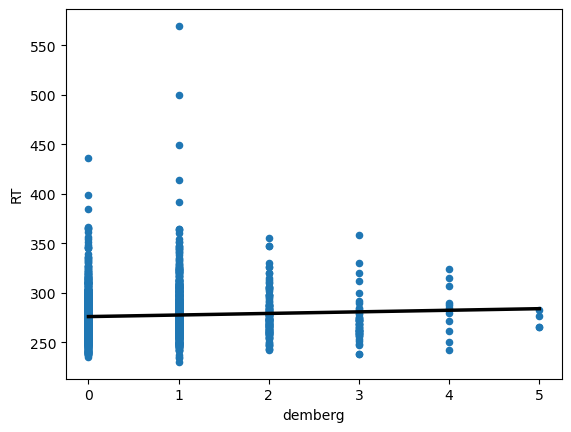

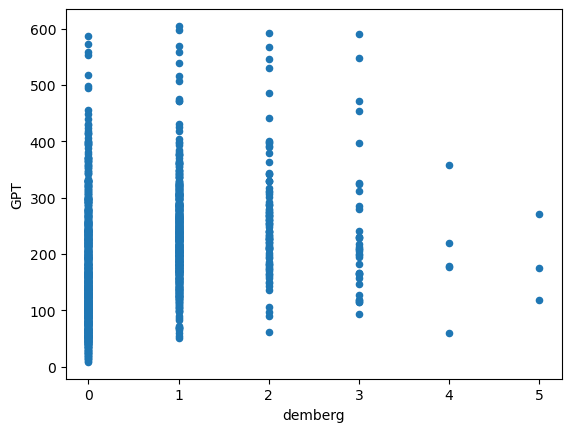

In [43]:
regression(frank_both_proportional_grouped2, "demberg", "RT")
regression(frank_both_proportional_grouped2, "demberg", "GPT")

/tmp/ipykernel_6786/2013034866.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby("binned_RT").mean(numeric_only=True).reset_index()


<Axes: xlabel='binned_RT'>

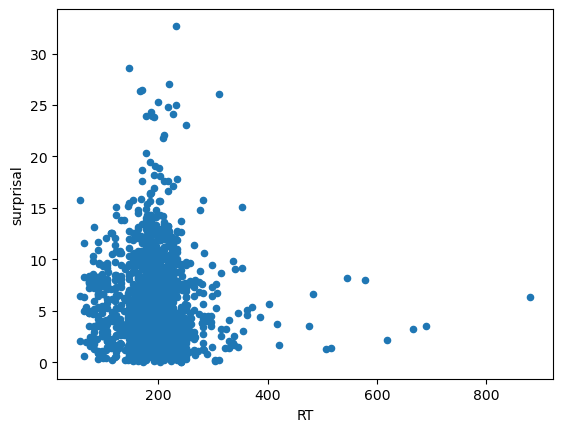

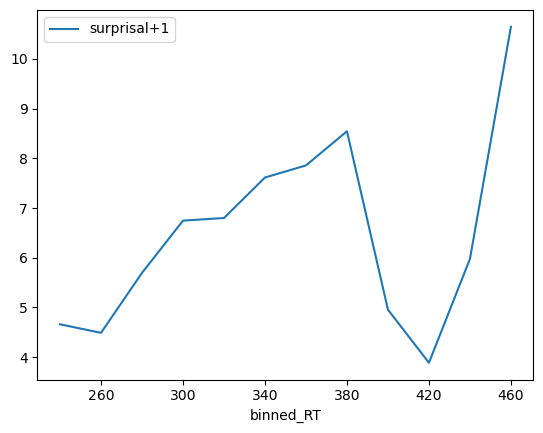

In [44]:
frank_both_proportional2[np.logical_and(frank_both_proportional2["WorkerId"] == 17, frank_both_proportional2["RT"] < 1000)].plot(kind="scatter", x="RT", y="surprisal")
bins = np.arange(0, 500, 20)
temp = frank_both_proportional_grouped2.copy()
pd.cut(frank_both_proportional_grouped2['RT'], bins, labels=bins[1:])
temp["binned_RT"] = pd.cut(frank_both_proportional_grouped2['RT'], bins, labels=bins[1:])
temp = temp.groupby("binned_RT").mean(numeric_only=True).reset_index()
temp.plot(x="binned_RT", y="surprisal+1")


<Axes: xlabel='RT', ylabel='surprisal_n'>

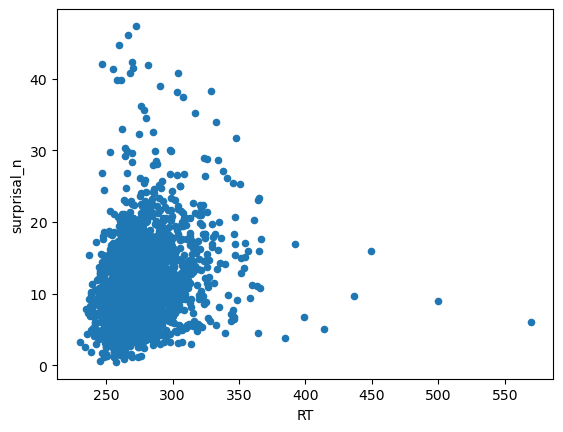

In [45]:
frank_both_proportional_grouped2["surprisal_n"] = frank_both_proportional_grouped2["surprisal"] + frank_both_proportional_grouped2["surprisal+1"]
frank_both_proportional_grouped2.plot(kind="scatter", x="RT", y="surprisal_n")

<Axes: xlabel='position'>

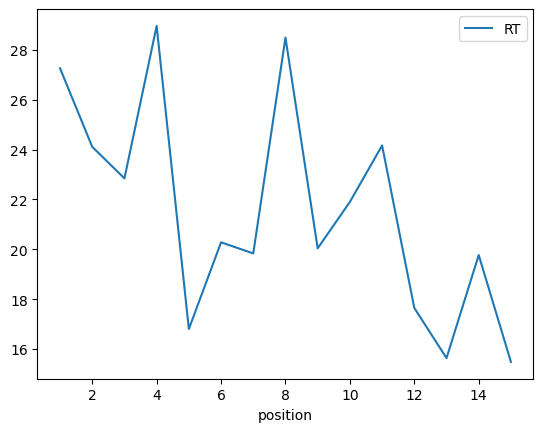

In [46]:
frank_both_proportional_grouped2.groupby(["position"]).std(numeric_only=True).reset_index().plot(x="position", y="RT")

<Axes: xlabel='GPT', ylabel='surprisal'>

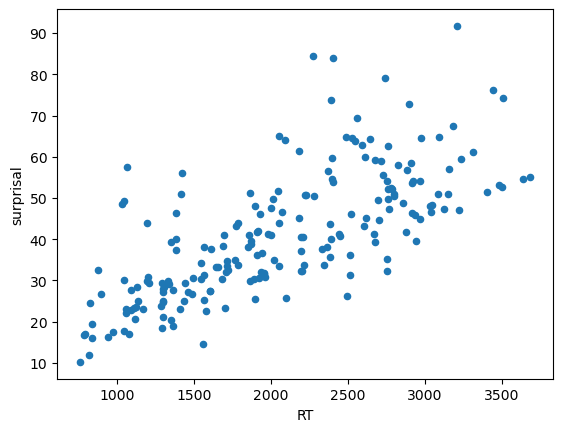

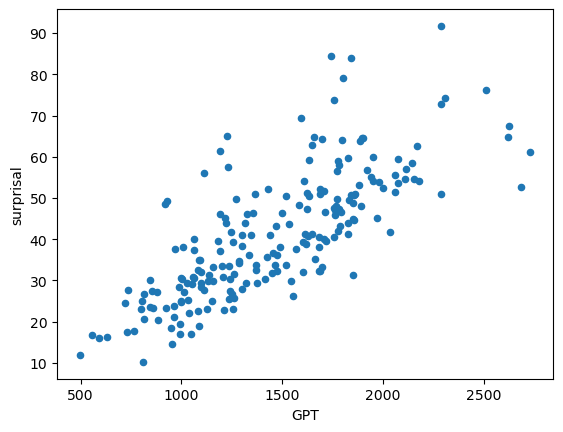

In [47]:
by_item = frank_both_proportional_grouped2.groupby(["item"]).sum(numeric_only=True)
by_item = by_item[by_item["RT"] != 0]
by_item = by_item[by_item["GPT"] != 0]
by_item.plot(kind="scatter", x="RT", y="surprisal")
by_item.plot(kind="scatter", x="GPT", y="surprisal")

/tmp/ipykernel_6786/977804368.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  minmaxnormalise(frank_both_proportional_grouped2.groupby(["binned"])[["surprisal", "RT", "FFD", "GPT", "-zone"]].mean()).plot()


<Axes: xlabel='binned'>

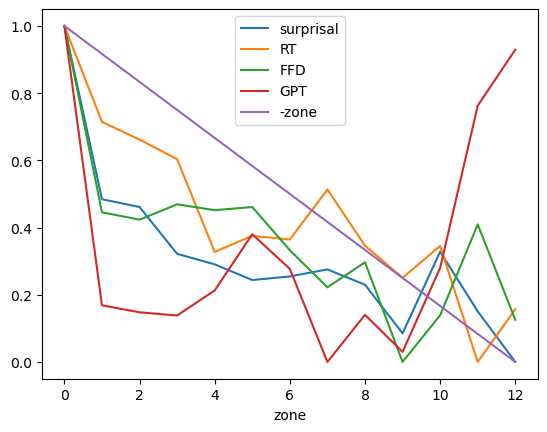

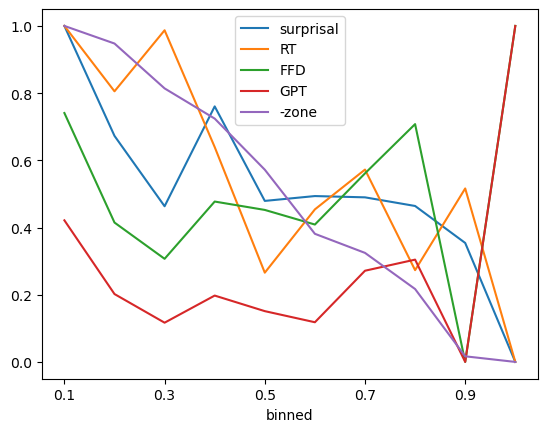

In [67]:
minmaxnormalise(frank_both_proportional_grouped2.groupby(["zone"])[["surprisal", "RT", "FFD", "GPT", "-zone"]].mean()).plot()
minmaxnormalise(frank_both_proportional_grouped2.groupby(["binned"])[["surprisal", "RT", "FFD", "GPT", "-zone"]].mean()).plot()

In [49]:
frank_both_proportional_grouped2

,item,position,zone,WorkerId,FFD,GPT,frequency,length,surprisal,head_distance,...,expected_distance.2_y,kl_divergence.2_y,surprisal.s.1_y,surprisal.s.2_y,zone_max,zone_max2,percent_of_sent,binned,-zone,surprisal_n
0,1,1,0.0,52.420455,158.790698,244.930233,5.39,4.0,8.091506,0.0,...,1.199699,6.050330,8.133706,3.779719,2.0,2.0,0.000000,NaN,-0.0,16.225212
1,1,2,1.0,52.420455,158.883721,204.744186,5.40,7.0,3.779719,-1.0,...,2.551514,5.202012,8.091506,4.872049,2.0,2.0,0.500000,0.5,-1.0,11.871225
2,1,3,2.0,52.420455,59.627907,108.651163,7.41,3.0,4.872049,0.0,...,2.176645,6.689727,3.779719,17.839870,2.0,2.0,1.000000,1.0,-2.0,8.651768
3,2,1,0.0,52.730337,168.952381,296.571429,5.04,5.0,10.056364,0.0,...,0.383198,3.464128,11.168557,5.165341,2.0,2.0,0.000000,NaN,-0.0,21.224921
4,2,2,1.0,52.730337,72.952381,84.285714,6.91,2.0,5.165341,0.0,...,1.212150,7.321413,10.056364,0.902529,2.0,2.0,0.500000,0.5,-1.0,15.221705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,249,9,8.0,60.423077,NaN,NaN,4.83,5.0,13.729698,-3.0,...,3.768193,9.315699,5.341407,10.876866,12.0,12.0,0.666667,0.7,-8.0,19.071105
2044,249,10,9.0,60.423077,NaN,NaN,6.50,4.0,10.876866,0.0,...,3.123248,9.584754,13.729698,23.056422,12.0,12.0,0.750000,0.8,-9.0,24.606565
2045,249,11,10.0,60.423077,NaN,NaN,5.09,8.0,23.056422,2.0,...,3.801167,11.091600,10.876866,17.806862,12.0,12.0,0.833333,0.9,-10.0,33.933288
2046,249,13,11.0,60.423077,NaN,NaN,4.57,6.0,17.806862,-4.0,...,4.849627,11.483115,23.056422,1.669873,12.0,12.0,0.916667,1.0,-11.0,40.863284


In [50]:
frank_both_proportional_grouped2

,item,position,zone,WorkerId,FFD,GPT,frequency,length,surprisal,head_distance,...,expected_distance.2_y,kl_divergence.2_y,surprisal.s.1_y,surprisal.s.2_y,zone_max,zone_max2,percent_of_sent,binned,-zone,surprisal_n
0,1,1,0.0,52.420455,158.790698,244.930233,5.39,4.0,8.091506,0.0,...,1.199699,6.050330,8.133706,3.779719,2.0,2.0,0.000000,NaN,-0.0,16.225212
1,1,2,1.0,52.420455,158.883721,204.744186,5.40,7.0,3.779719,-1.0,...,2.551514,5.202012,8.091506,4.872049,2.0,2.0,0.500000,0.5,-1.0,11.871225
2,1,3,2.0,52.420455,59.627907,108.651163,7.41,3.0,4.872049,0.0,...,2.176645,6.689727,3.779719,17.839870,2.0,2.0,1.000000,1.0,-2.0,8.651768
3,2,1,0.0,52.730337,168.952381,296.571429,5.04,5.0,10.056364,0.0,...,0.383198,3.464128,11.168557,5.165341,2.0,2.0,0.000000,NaN,-0.0,21.224921
4,2,2,1.0,52.730337,72.952381,84.285714,6.91,2.0,5.165341,0.0,...,1.212150,7.321413,10.056364,0.902529,2.0,2.0,0.500000,0.5,-1.0,15.221705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,249,9,8.0,60.423077,NaN,NaN,4.83,5.0,13.729698,-3.0,...,3.768193,9.315699,5.341407,10.876866,12.0,12.0,0.666667,0.7,-8.0,19.071105
2044,249,10,9.0,60.423077,NaN,NaN,6.50,4.0,10.876866,0.0,...,3.123248,9.584754,13.729698,23.056422,12.0,12.0,0.750000,0.8,-9.0,24.606565
2045,249,11,10.0,60.423077,NaN,NaN,5.09,8.0,23.056422,2.0,...,3.801167,11.091600,10.876866,17.806862,12.0,12.0,0.833333,0.9,-10.0,33.933288
2046,249,13,11.0,60.423077,NaN,NaN,4.57,6.0,17.806862,-4.0,...,4.849627,11.483115,23.056422,1.669873,12.0,12.0,0.916667,1.0,-11.0,40.863284


In [90]:
from sklearn import linear_model
from sklearn import preprocessing

temp = frank_both_proportional_grouped2.dropna(subset=["surprisal"])
X = temp[["surprisal"]]
y = temp[["RT"]]

lm = linear_model.LinearRegression()
reg = linear_model.LinearRegression().fit(X, y)
preds = reg.predict(X)
reg.score(X, y)

0.02690404553339676

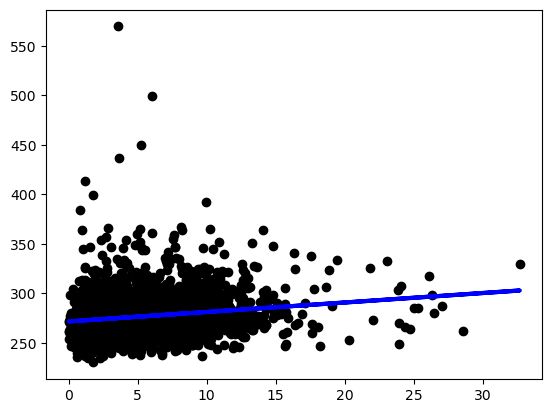

In [91]:
plt.scatter(X, y, color="black")
plt.plot(X, preds, color="blue", linewidth=3)

plt.show()

In [92]:
X = temp[["surprisal"]]

poly = preprocessing.PolynomialFeatures(2)
X = poly.fit_transform(X)

reg = linear_model.LinearRegression().fit(X, y)
reg.score(X, y)

0.027791898137768056

In [93]:
X = temp[["surprisal+1"]]

poly = preprocessing.PolynomialFeatures(2)
X = poly.fit_transform(X)

reg = linear_model.LinearRegression().fit(X, y)
reg.score(X, y)

0.04627677065028568

In [94]:
X = temp[["surprisal", "surprisal+1"]]

poly = preprocessing.PolynomialFeatures(2)
X = poly.fit_transform(X)

reg = linear_model.LinearRegression().fit(X, y)
reg.score(X, y)

0.07531335875797451

In [95]:
X = temp[["surprisal", "surprisal+1", "position", "demberg", "demberg+1", "demberg-1"]]

poly = preprocessing.PolynomialFeatures(2)
X = poly.fit_transform(X)

reg = linear_model.LinearRegression().fit(X, y)
reg.score(X, y)

0.08524723514530996

In [96]:
# Analyse the errors made by the linear regression to find out where surprisal underexplains

temp = frank_both_proportional_grouped2.dropna(subset=["surprisal"])
X = temp[["surprisal"]]
y = temp[["RT"]]

lm = linear_model.LinearRegression()
reg = linear_model.LinearRegression().fit(X, y)
error = reg.predict(X) - y

columns = temp.select_dtypes(include=[np.number]).dropna(axis="columns").columns
results = []
for column in columns:
    X2 = temp[[column]]
    lm2 = linear_model.LinearRegression()
    reg2 = linear_model.LinearRegression().fit(X2, error)
    results.append(reg2.score(X2, error))

pd.DataFrame({"column": columns, "score": [round(value, 3) for value in results]})


,column,score
0,item,0.001
1,position,0.007
2,zone,0.009
3,WorkerId,0.003
4,frequency,0.000
5,length,0.005
6,surprisal,0.000
7,head_distance,0.004
8,first_dependent_distance,0.001
9,left_dependents_distance_sum,0.001
